<a href="https://colab.research.google.com/github/LanaGavris/-Brain-Cancer-detection/blob/main/Brain_Cancer_detection_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Learning Problem and dataset explaination**

The learning problem is a supervised classification task focused on identifying brain tumor types from MRI images. The goal is to categorize images into three classes: No Tumor, Meningioma,Glioma,Pituitary. The dataset, sourced from the "Bangladesh Brain Cancer MRI Dataset" on Mendeley Data, consists of a total of 6056 MRI images. This project aims to develop a model capable of accurately classifying these MRI scans.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [4]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [5]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [6]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [7]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')

In [8]:
tr_df

Class Path      Class
0     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
...                                                 ...        ...
5707  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5708  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5709  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5710  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5711  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma

[5712 rows x 2 columns]

In [9]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [10]:
ts_df

Class Path      Class
0     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
...                                                 ...        ...
1306  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1307  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1308  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1309  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1310  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma

[1311 rows x 2 columns]

In [11]:
print(f"Train_df shape: {tr_df.shape}")
print(f"Test_df shape: {ts_df.shape}")
print("\nClass distribution in training set:")
print(tr_df['Class'].value_counts())
print("\nClass distribution in testing set:")
print(ts_df['Class'].value_counts())

Train_df shape: (5712, 2)
Test_df shape: (1311, 2)

Class distribution in training set:
Class
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

Class distribution in testing set:
Class
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64


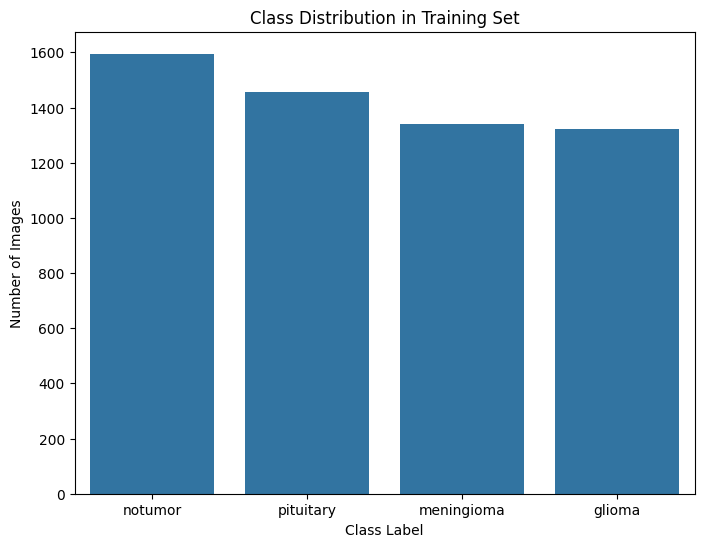

Class counts in training set:
            count
Class            
notumor      1595
pituitary    1457
meningioma   1339
glioma       1321


In [12]:
# EDA - Class Distribution in Testing Set

if 'tr_df' not in locals() or tr_df.empty:
    print("Warning: 'train_df' is not defined or is empty. Skipping training set distribution plot.")
else:
    # Visualize the number of images per class in the training set.
    # This helps to check for class imbalance, which might affect model training.
    plt.figure(figsize=(8, 6))
    sns.countplot(data=tr_df, x='Class', order=tr_df['Class'].value_counts().index)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Images')
    # plt.savefig('eda_train_class_distribution.png') # Optional: save plot
    plt.show() # Display the plot

    print("Class counts in training set:")
    print(tr_df['Class'].value_counts().to_frame())

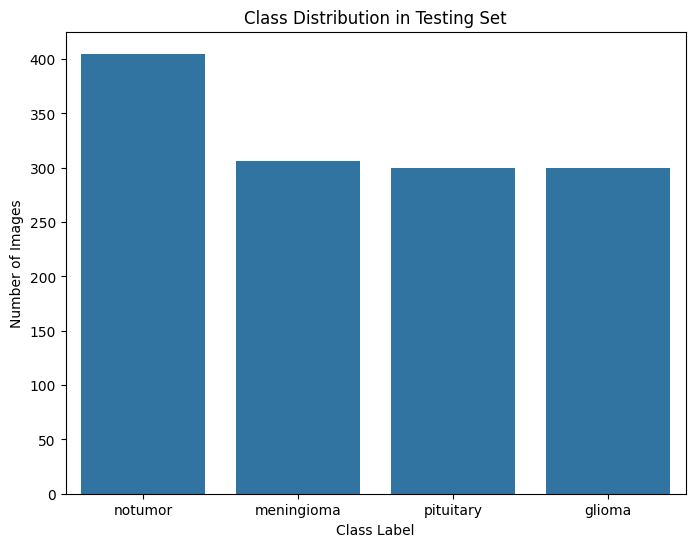

Class counts in testing set:
            count
Class            
notumor       405
meningioma    306
pituitary     300
glioma        300


In [13]:
# EDA - Class Distribution in Testing Set

if 'ts_df' not in locals() or ts_df.empty:
    print("Warning: 'test_df' is not defined or is empty. Skipping testing set distribution plot.")
else:
    # Visualize the number of images per class in the testing set.
    # This helps ensure the test set has a representative distribution for fair evaluation.
    plt.figure(figsize=(8, 6))
    sns.countplot(data=ts_df, x='Class', order=ts_df['Class'].value_counts().index)
    plt.title('Class Distribution in Testing Set')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Images')
    # plt.savefig('eda_test_class_distribution.png') # Optional: save plot
    plt.show() # Display the plot

    print("Class counts in testing set:")
    print(ts_df['Class'].value_counts().to_frame())

### split the testing data to test and validation data

In [14]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [15]:
valid_df

Class Path       Class
1297  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
723   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
61    /kaggle/input/brain-tumor-mri-dataset/Testing/...   pituitary
778   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
1120  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
...                                                 ...         ...
1070  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
554   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor
1284  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
899   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
626   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor

[655 rows x 2 columns]

### Data preprocessing


In [16]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


### Getting samples from data

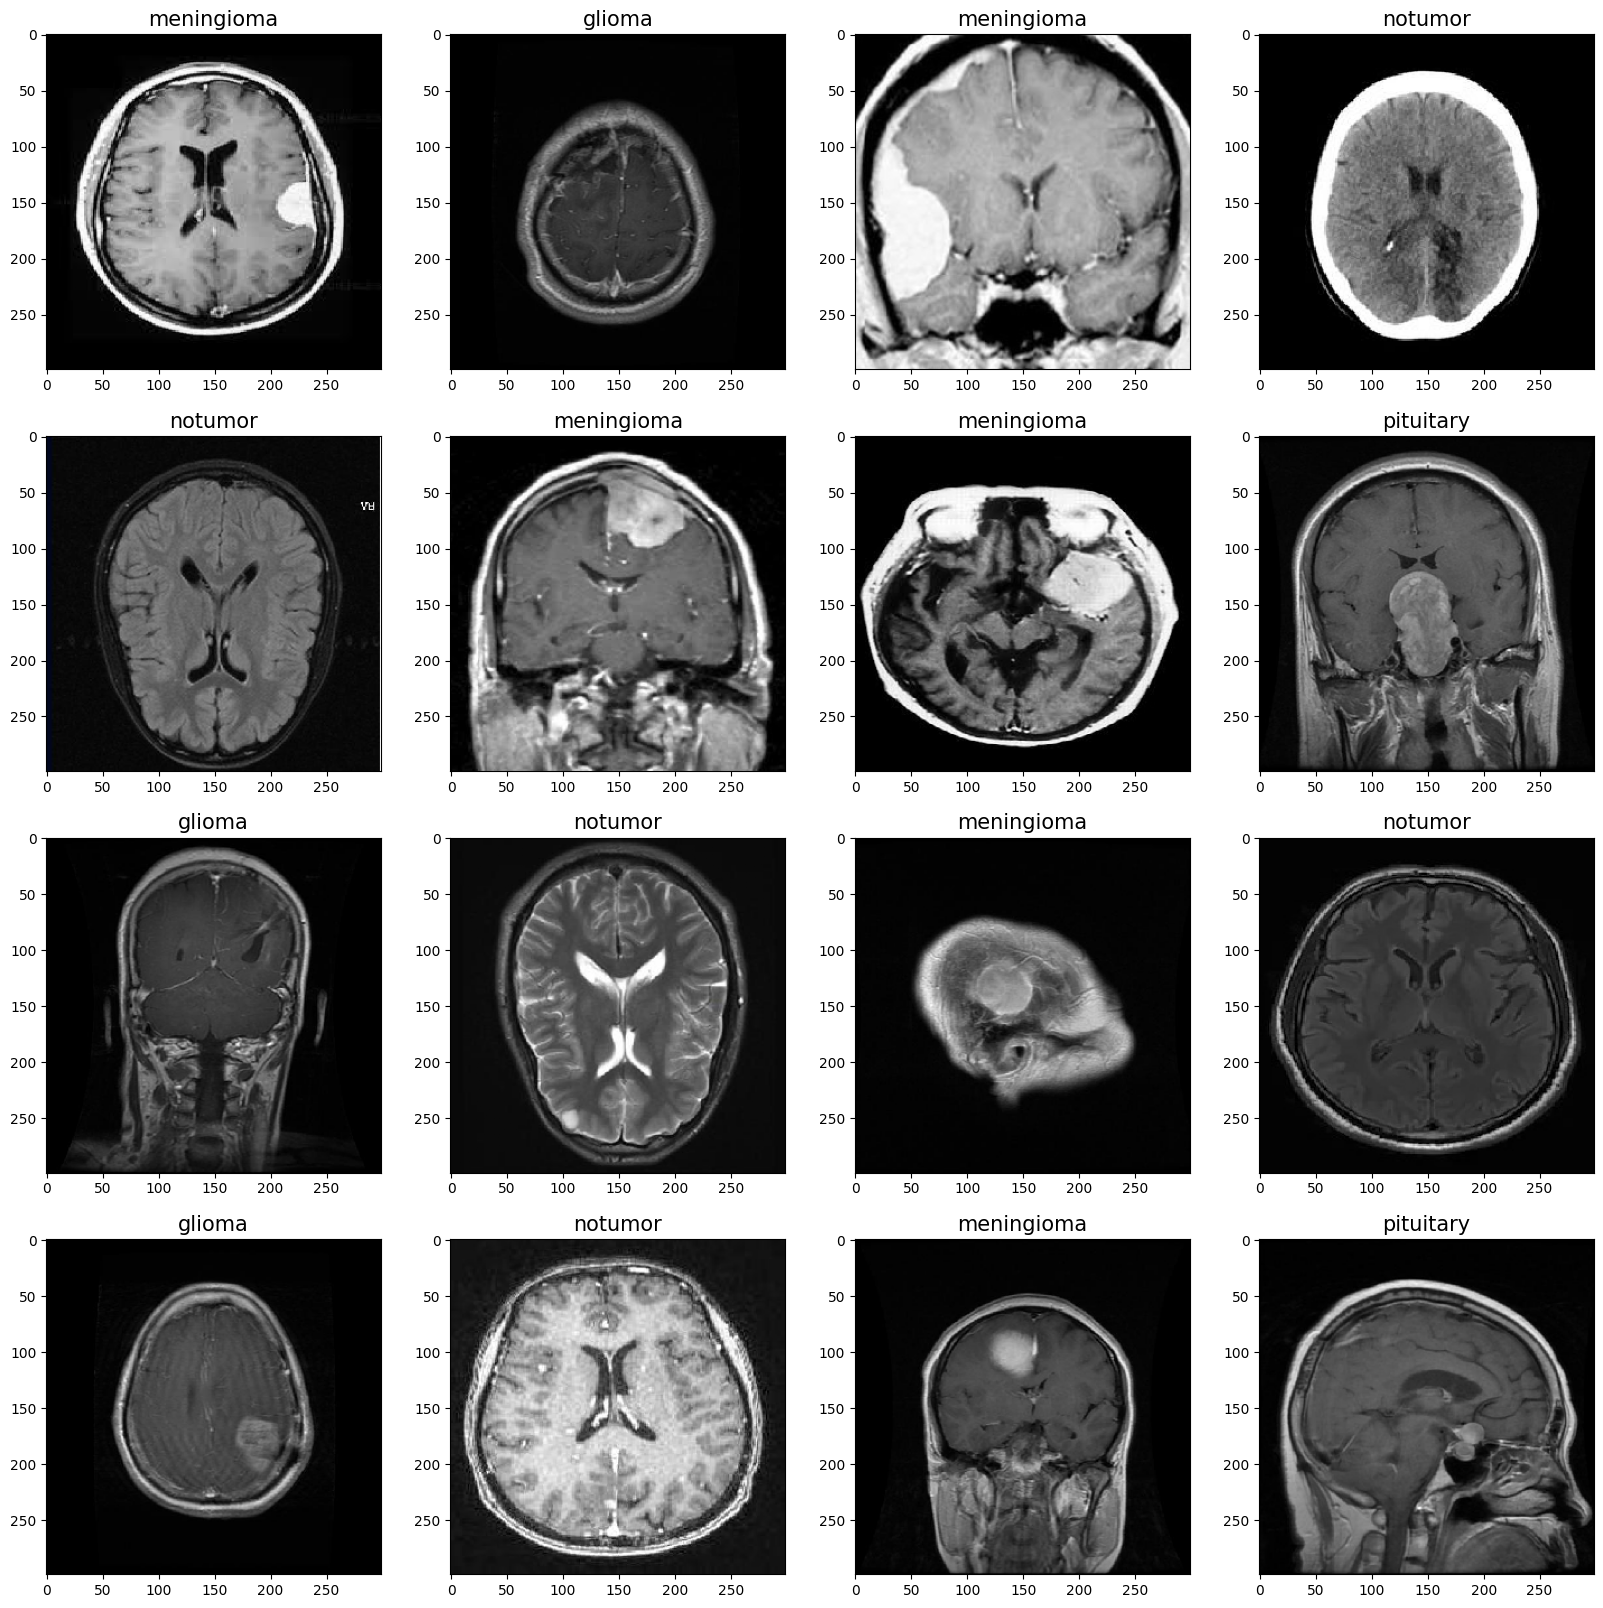

In [17]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

## **2. Building Deep Learning Model**

In [18]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

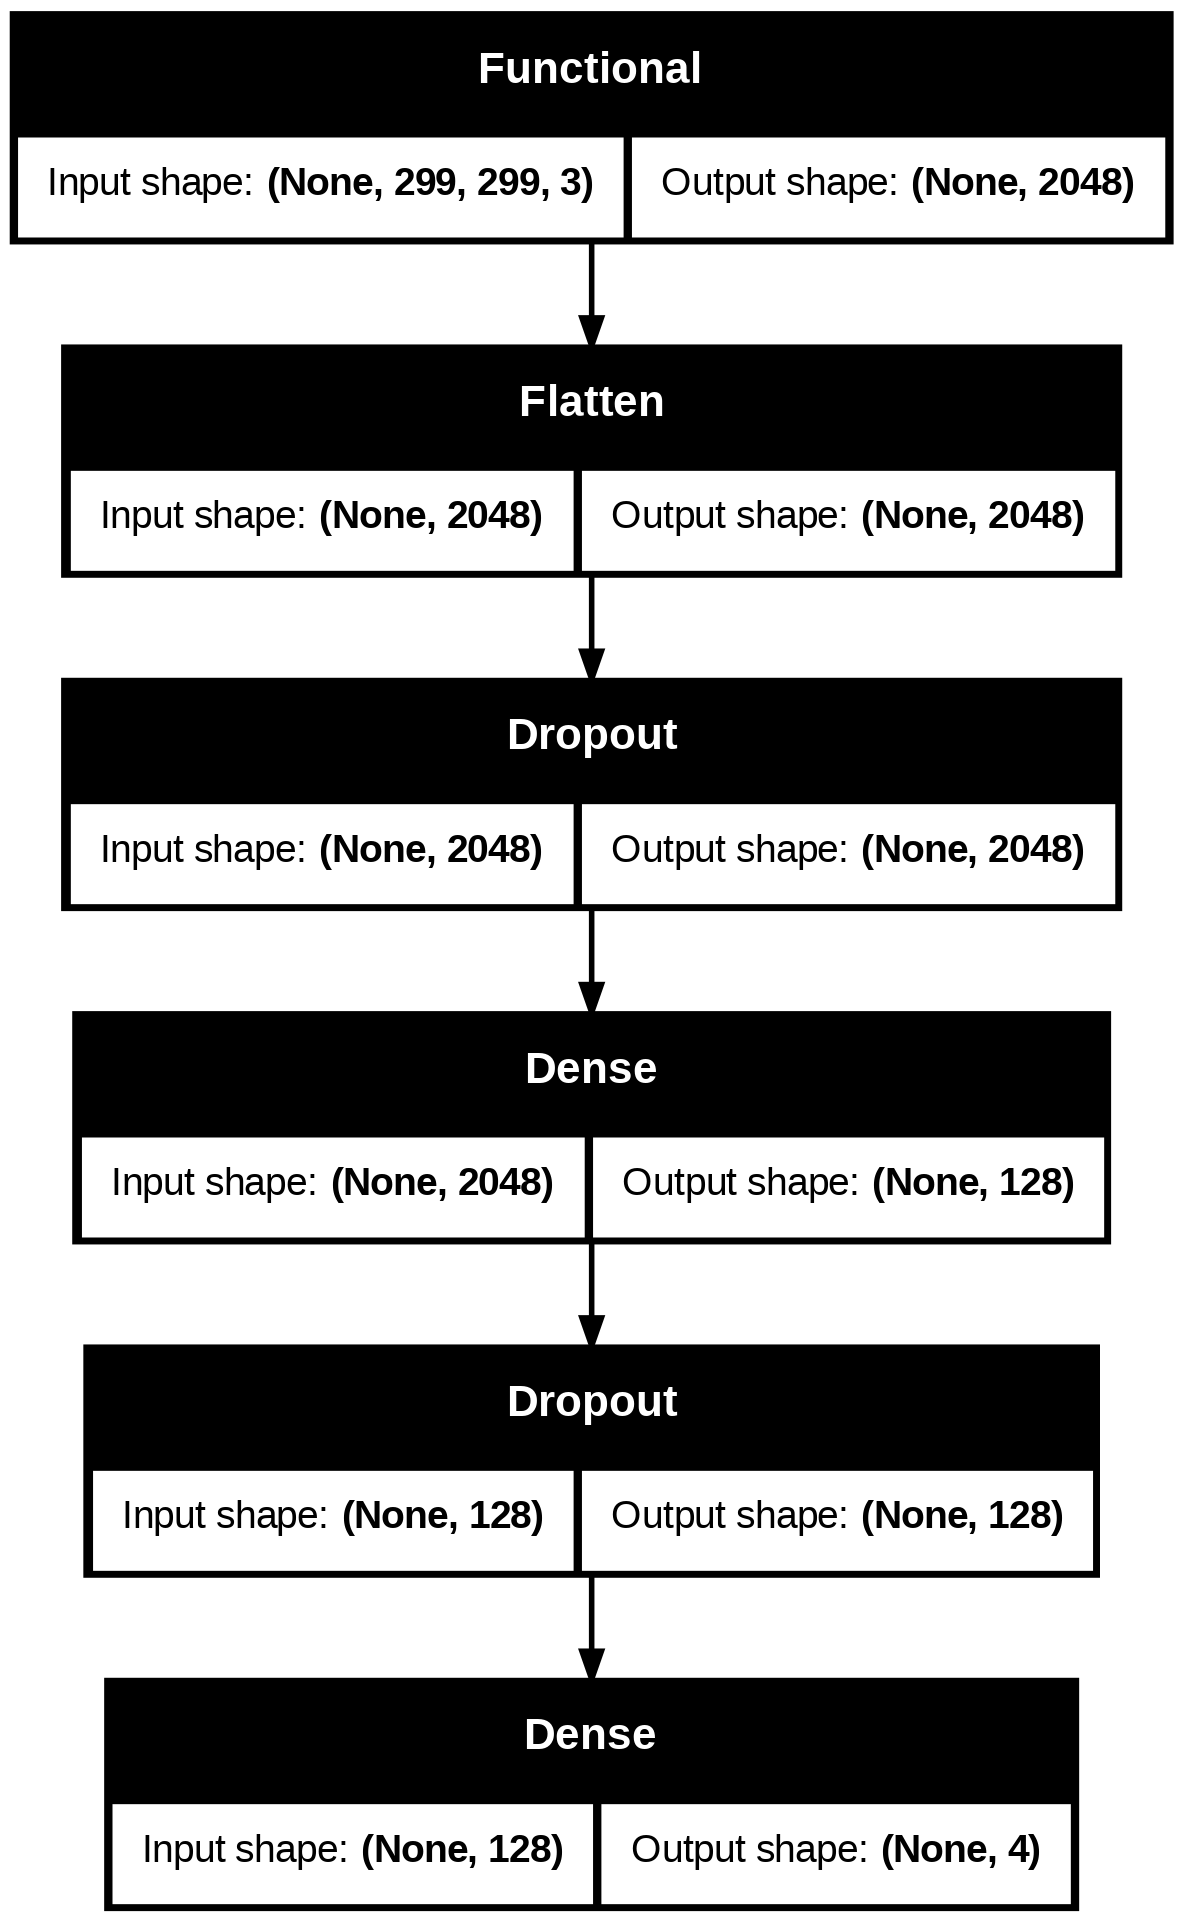

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

# **3.Training**

In [21]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.7967 - loss: 0.5906 - precision: 0.8501 - recall: 0.7217 - val_accuracy: 0.9405 - val_loss: 0.1608 - val_precision: 0.9474 - val_recall: 0.9344
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 167s 930ms/step - accuracy: 0.9767 - loss: 0.0760 - precision: 0.9784 - recall: 0.9735 - val_accuracy: 0.9573 - val_loss: 0.1131 - val_precision: 0.9601 - val_recall: 0.9542
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 166s 929ms/step - accuracy: 0.9916 - loss: 0.0290 - precision: 0.9925 - recall: 0.9913 - val_accuracy: 0.9771 - val_loss: 0.0790 - val_precision: 0.9771 - val_recall: 0.9756
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 166s 929ms/step - accuracy: 0.9947 - loss: 0.0210 - precision: 0.9949 - recall: 0.9942 - val_accuracy: 0.9985 - val_loss: 0.0065 - val_precision: 0.9985 - val_recall: 0.9985
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 167s 930ms/step - accuracy: 0.9955 - loss: 0.0159 - precision: 0.9955 - recall: 0.9954 - val_accuracy: 0.99

In [22]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

# **4.Visualize model performance**

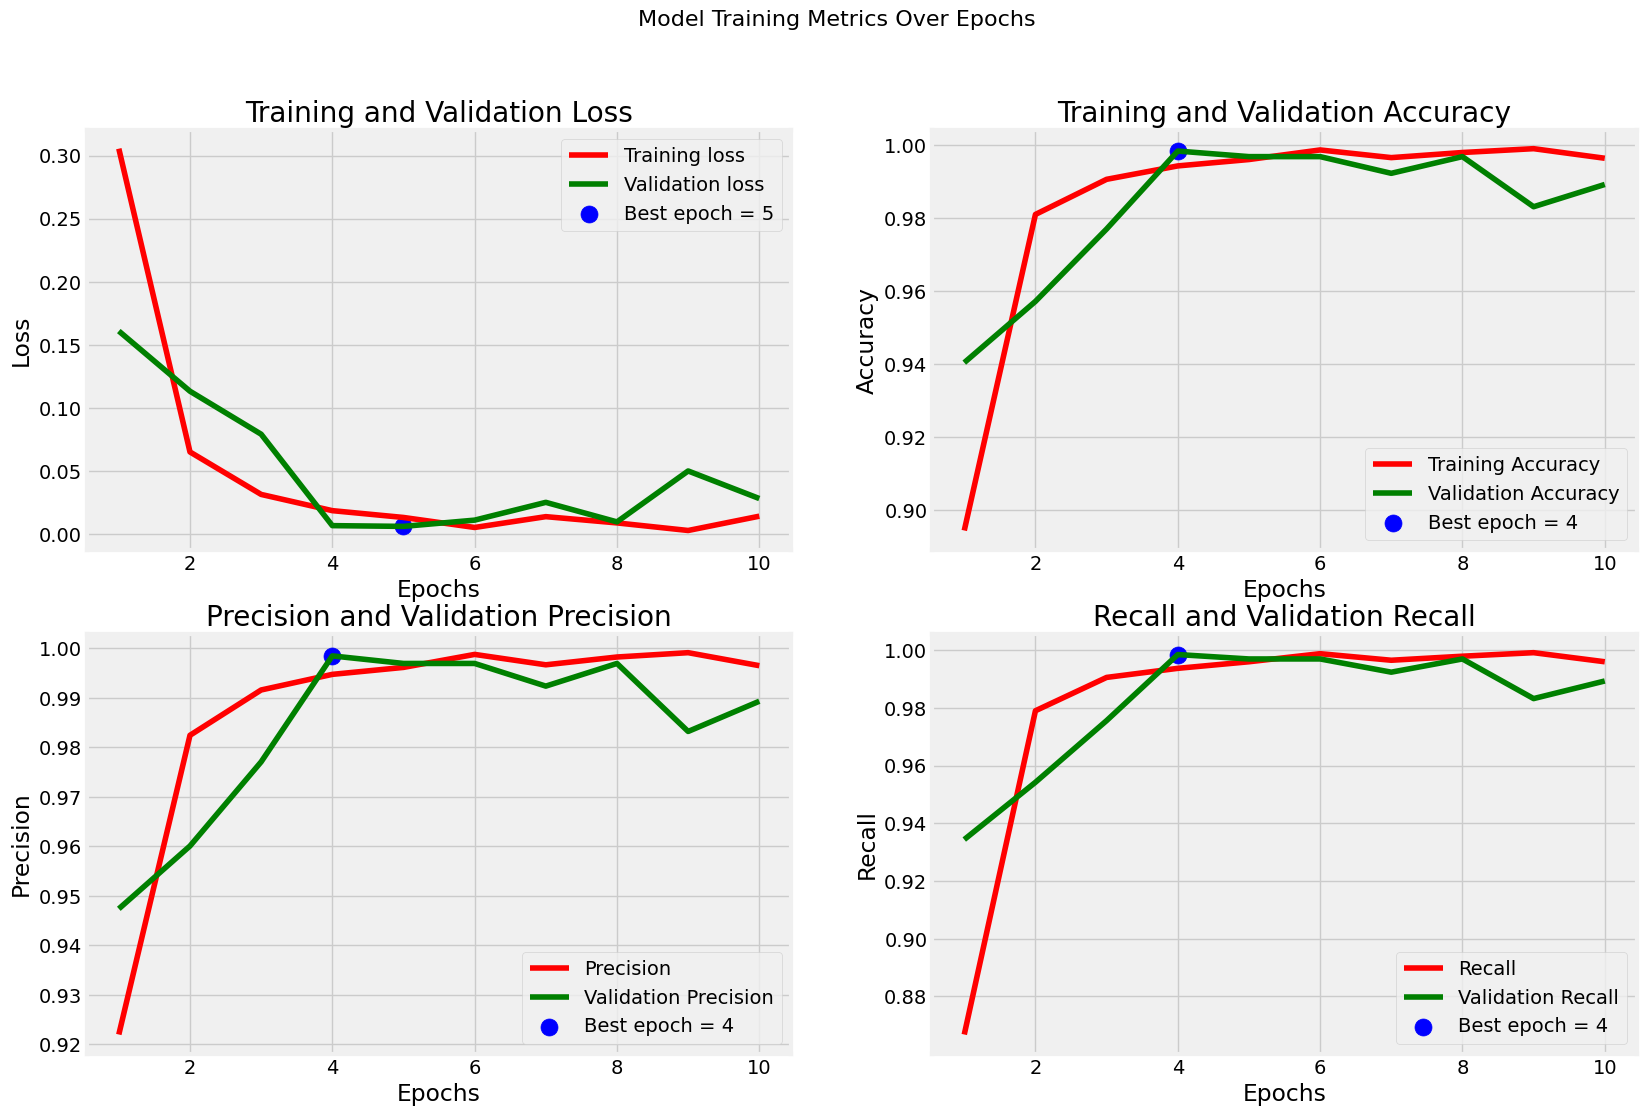

In [23]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# **5.Testing and Evaluation**

In [24]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 391ms/step - accuracy: 0.9944 - loss: 0.0194 - precision: 0.9944 - recall: 0.9938
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.9953 - loss: 0.0121 - precision: 0.9953 - recall: 0.9953
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9812 - loss: 0.0644 - precision: 0.9812 - recall: 0.9812
Train Loss: 0.0141
Train Accuracy: 99.51%
--------------------
Validation Loss: 0.0299
Validation Accuracy: 98.93%
--------------------
Test Loss: 0.1004
Test Accuracy: 97.71%


In [25]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step


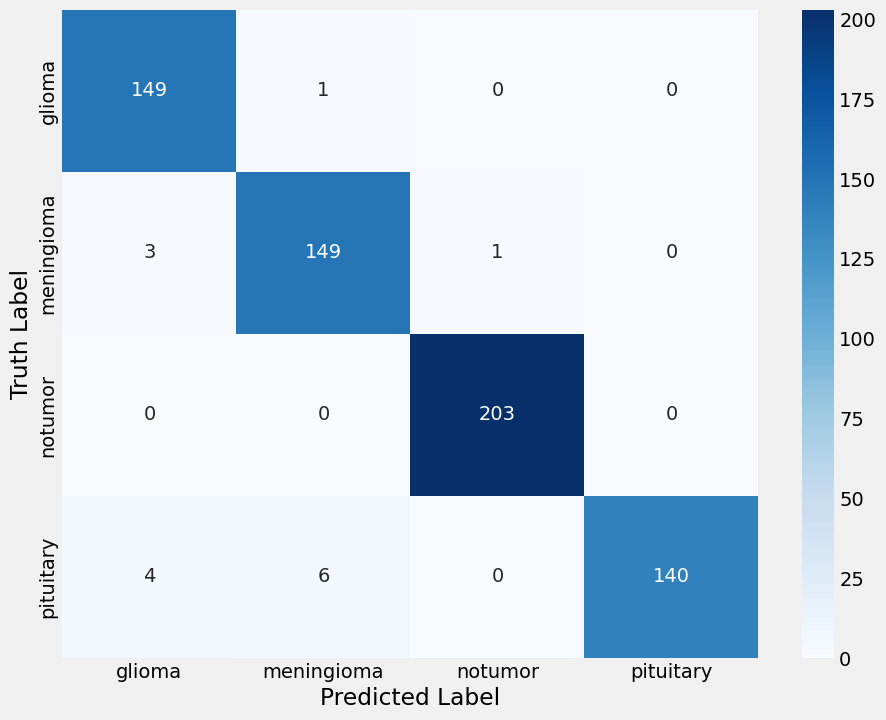

In [26]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [27]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       150
           1       0.96      0.97      0.96       153
           2       1.00      1.00      1.00       203
           3       1.00      0.93      0.97       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



5.2 Testing

In [28]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


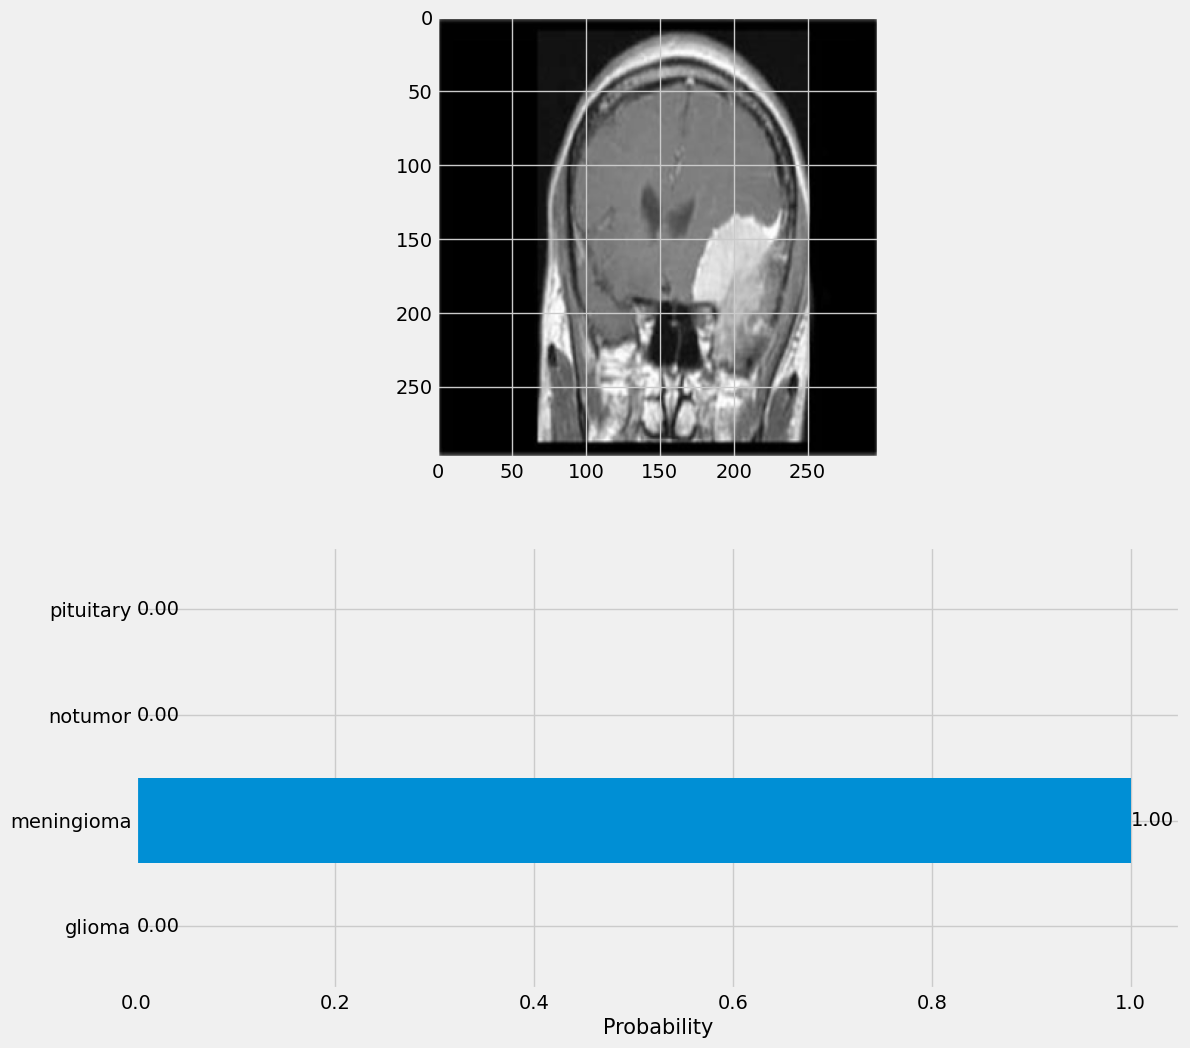

In [29]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

In [35]:
#  Get class dictionary and list of class names
class_dict = ts_gen.class_indices
classes = list(class_dict.keys())

#Get one batch of images and true labels from the test generator
# The test generator (ts_gen) is crucial here as it should not be shuffled.
images, true_labels_encoded = next(ts_gen)

preds = model.predict(images)

# Convert encoded (one-hot) true labels and probability predictions to class indices
true_labels_index = np.argmax(true_labels_encoded, axis=1)
predicted_labels_index = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


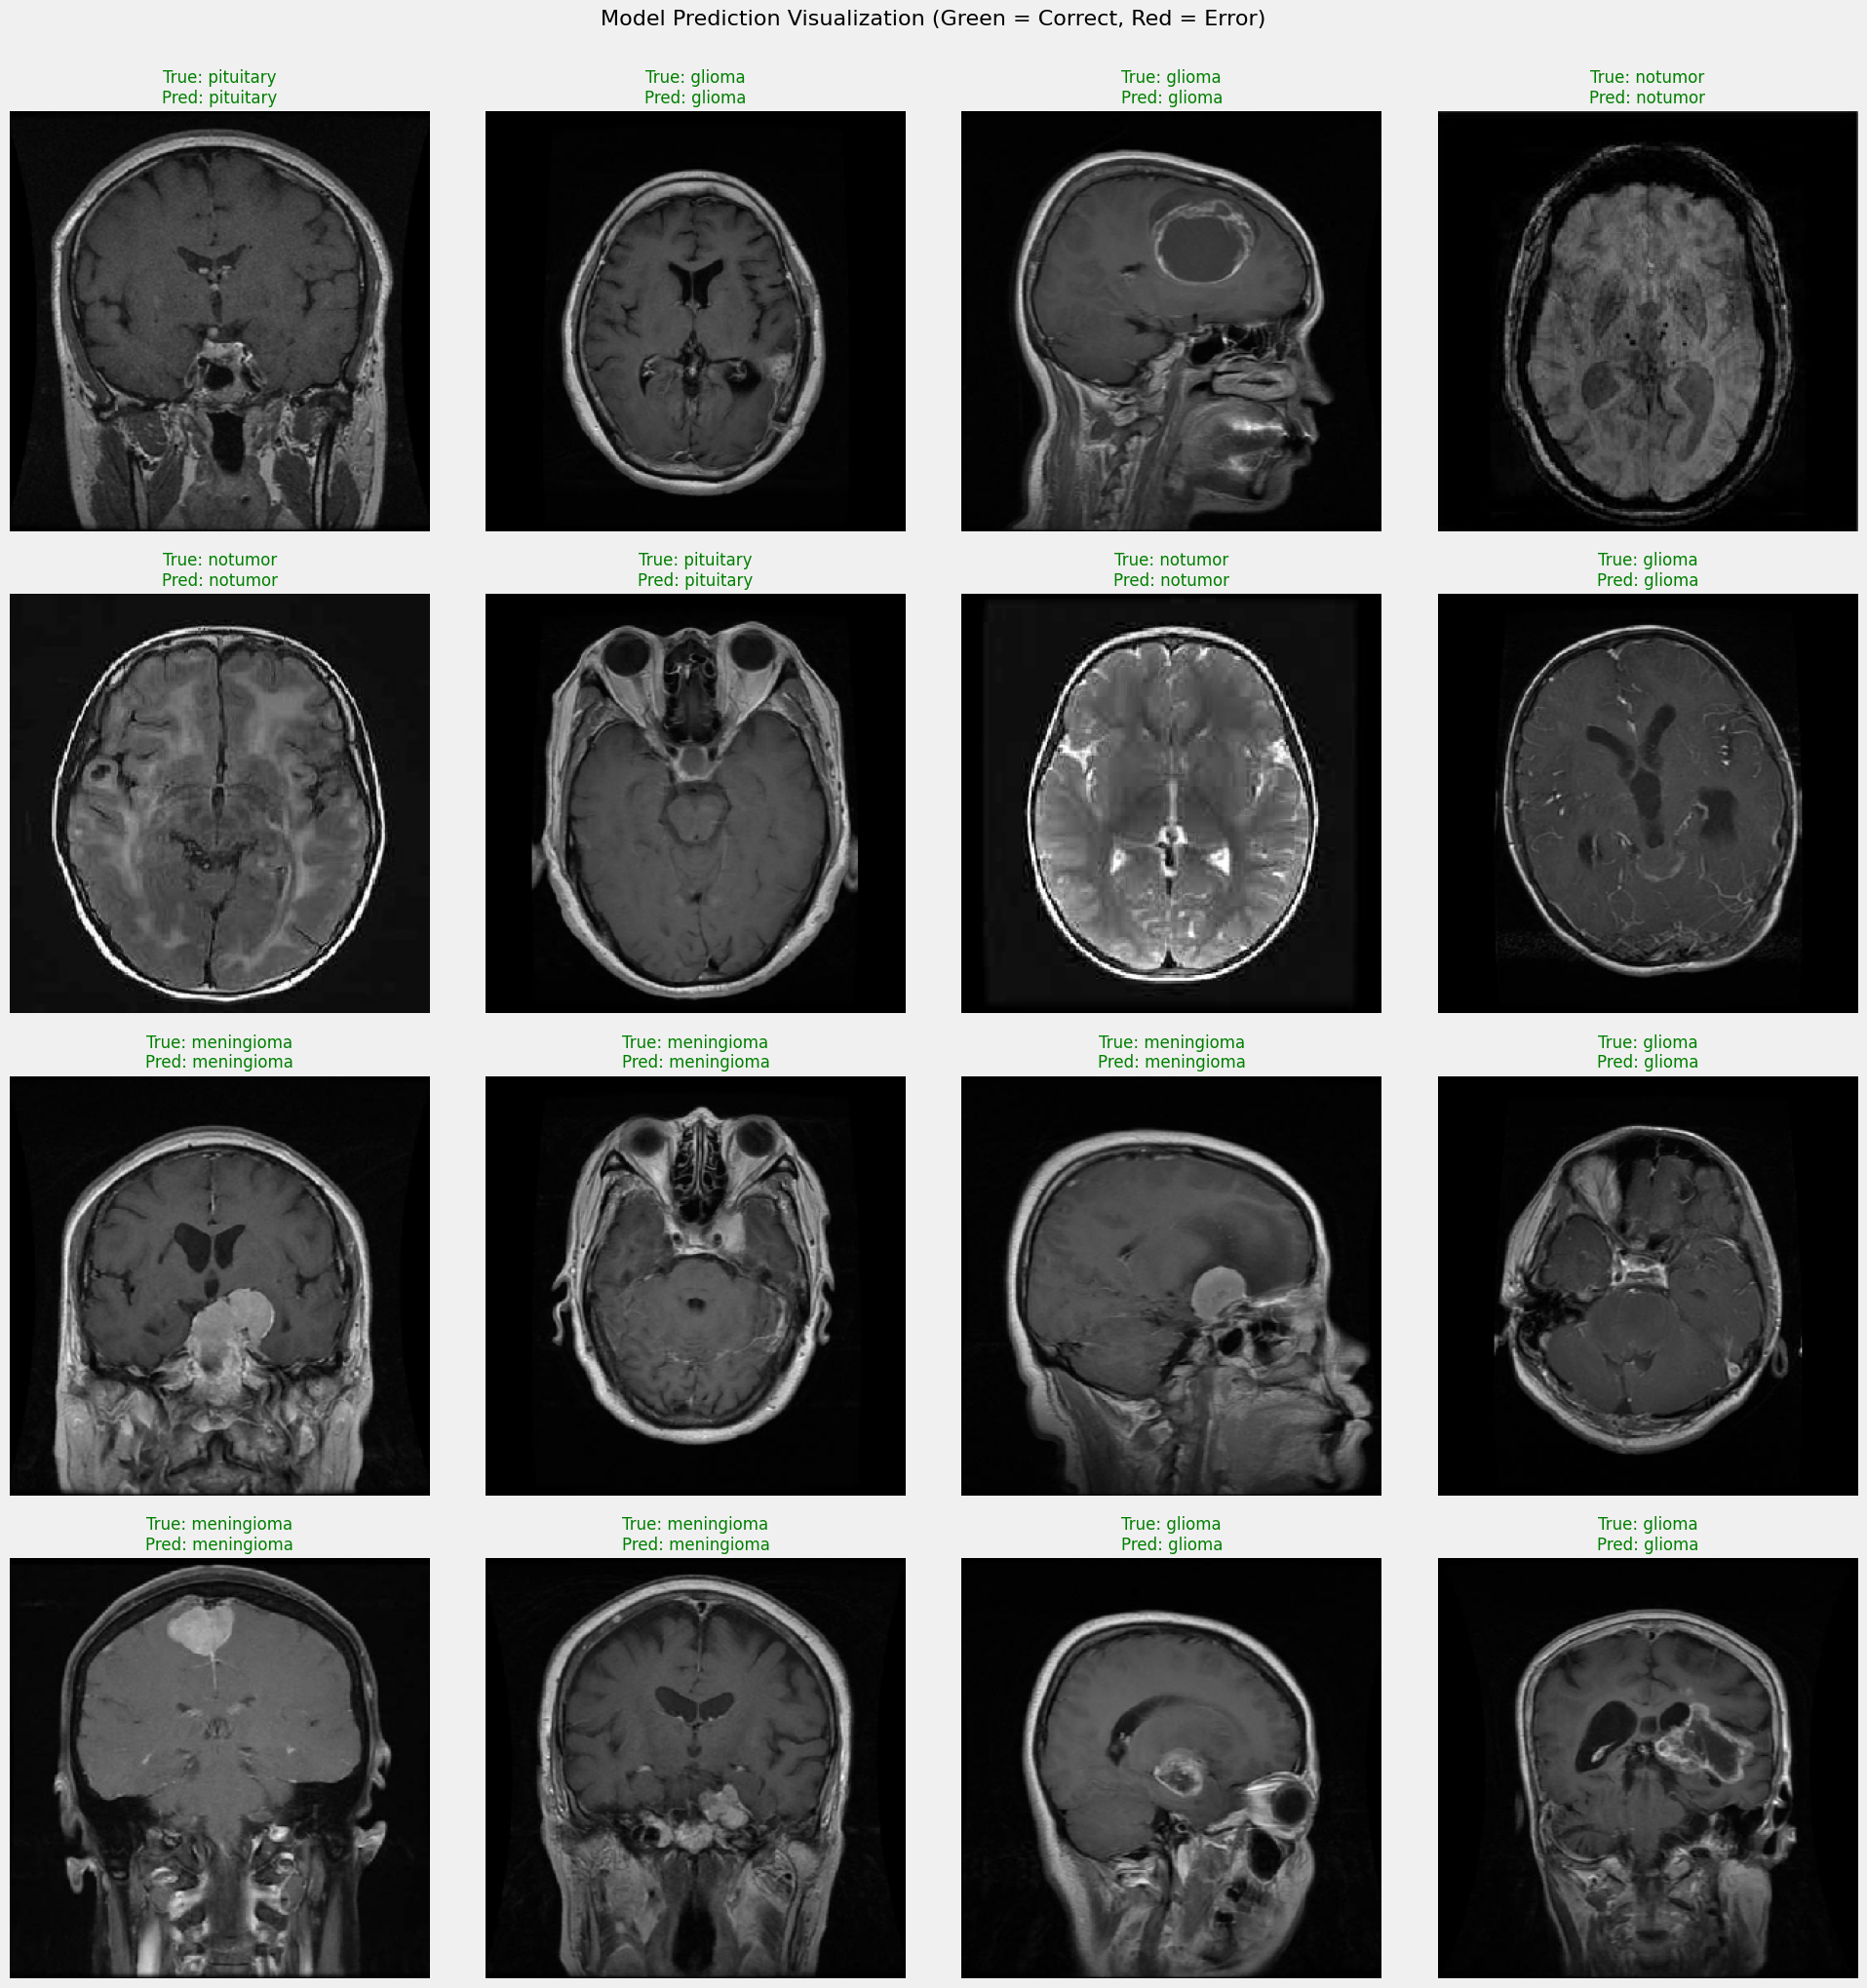

In [36]:
# Configure plot size
plt.figure(figsize=(20, 20))
num_images_to_show = min(16, len(images))

for i in range(num_images_to_show):
    plt.subplot(4, 4, i + 1)

    # Get the true and predicted class names
    true_class = classes[true_labels_index[i]]
    predicted_class = classes[predicted_labels_index[i]]

    # Check if the prediction is correct
    is_correct = (true_class == predicted_class)
    color = 'green' if is_correct else 'red'

    title = f"True: {true_class}\nPred: {predicted_class}"

    # Display the image and the title
    # The images are already normalized [0, 1] by the generator
    plt.imshow(images[i])
    plt.title(title, color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Model Prediction Visualization (Green = Correct, Red = Error)', fontsize=16, y=1.02)
plt.show()